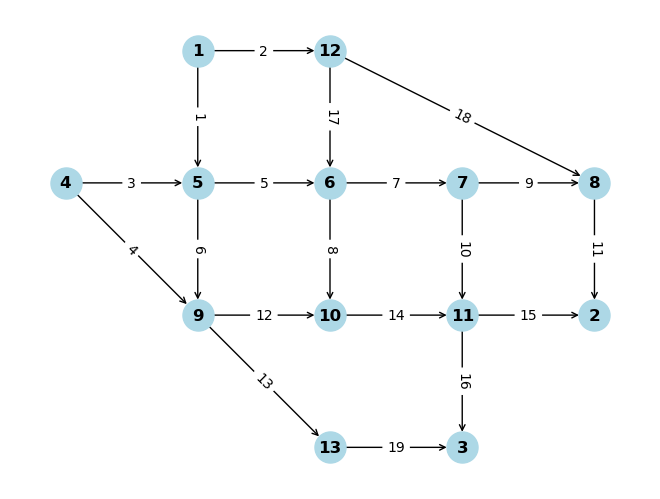

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
# 手动指定节点位置
pos = {
    1: (1, 4), 2: (4, 2), 3: (3, 1), 4: (0, 3), 
    5: (1, 3), 6: (2, 3), 7: (3, 3), 8: (4, 3),
    9: (1, 2), 10: (2, 2), 11: (3, 2), 12: (2, 4),
    13: (2, 1)
}
def generate_network_custom_layout():
    # 创建一个有向图
    G = nx.DiGraph()

    # 添加节点
    nodes = range(1, 14)
    G.add_nodes_from(nodes)

    # 添加有向边
    edges = [(1, 5), (1, 12), (4, 5), (4, 9), (5, 6), (5, 9), (6, 7), (6, 10),
             (7, 8), (7, 11), (8, 2), (9, 10), (9, 13), (10, 11), (11, 2),
             (11, 3), (12, 6), (12, 8), (13, 3)]
    G.add_edges_from(edges)

    # 设置节点属性
    node_labels = {node: str(node) for node in G.nodes}
    nx.set_node_attributes(G, node_labels, 'label')

    # 设置边属性
    edge_labels = {(edge[0], edge[1]): i for i, edge in enumerate(edges, 1)}
    nx.set_edge_attributes(G, edge_labels, 'label')



    # 绘制图形
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            node_size=500, arrowstyle='->', arrowsize=10,
            font_size=12, font_weight='bold')

    # 添加边标签
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # 显示图形
    #plt.show()

    return G



def get_upstream(G, edge_label):
    upstream_edges = set()
    for edge in G.in_edges():
        if G.edges[edge]['label'] == edge_label:
            start_node = edge[0]
            upstream_edges.update(G.edges[edge]['label'] for edge in G.in_edges(start_node))

    if not upstream_edges:
        upstream_edges = {-1}  # 用一个无效值替代空集合  
              
    return upstream_edges

def get_downstream(G, edge_label):
    downstream_edges = set()
    for edge in G.out_edges():
        if G.edges[edge]['label'] == edge_label:
            end_node = edge[1]
            downstream_edges.update(G.edges[edge]['label'] for edge in G.out_edges(end_node))
    
    if not downstream_edges:
        downstream_edges = {-1}  # 用一个无效值替代空集合
    
    return downstream_edges


# 生成网络
grid_graph = generate_network_custom_layout()


In [61]:
import gurobipy as gp
from gurobipy import GRB
import random

# 设置随机种子
random.seed(123)

# 创建模型
model = gp.Model("mip1")

# 定义参数N和M的值
N = 19  # 边的编号
M = 5   # 时间的编号
K = 1
M_range = range(1,M+1)
N_range = range(1,N+1)
K_range = range(1,K+1)
time_span = 2 #事故持续时间
# 创建二维变量矩阵P，并初始化为0
P = {}
P_initial = {}  # 用于保存P的初始值
for i in M_range:
    for j in N_range:
        P[i, j] = 0


origin_time_index = 1  # 事故发生时间
origin_link_index = 7  # 事故发生link

P[origin_time_index, origin_link_index] = 1

for i in range((origin_time_index + 1),(origin_time_index + 2 + time_span)):
    for j in get_upstream(grid_graph, origin_link_index):
        P[i, j] = 1

for i in range(origin_time_index,origin_time_index + time_span + 1):
    for j in range(origin_link_index,origin_link_index+1):
        P[i, j] = 1


for i in range((origin_time_index + 2),(origin_time_index + 3 + time_span)):
    for j in get_upstream(grid_graph, 5):
        P[i, j] = 1

for i in range((origin_time_index + 2),(origin_time_index + 3 + time_span)):
    for j in get_upstream(grid_graph, 17):
        P[i, j] = 1

for i in range(origin_time_index,origin_time_index + time_span + 1):
    for j in range(origin_link_index,origin_link_index+1):
        P[i, j] = 1

P[3,17]=0
# 随机选择noise个需要转换的值的索引
noise = 5
indices = []
while len(indices) < noise:
    index = random.choice(list(P.keys()))
    if index not in indices:
        indices.append(index)

#对选定的索引进行值的转换
# for index in indices:
#     P[index] = 1 - P[index]  # 直接修改P中的值

for i in M_range:
    for j in N_range:
        P_initial[i, j] = model.addVar(vtype=GRB.BINARY, name=f"P_initial[{i},{j}]")
        P_initial[i, j].LB = float(P[i, j])
        P_initial[i, j].UB = float(P[i, j])



model.update()


In [62]:
# 创建决策变量
gamma  = model.addVars(K_range,M_range,N_range,vtype=GRB.BINARY, name="gamma") #link n在时间区间m上确实受到了事故k影响则为1
delta  = model.addVars(K_range,M_range,N_range,vtype=GRB.BINARY, name="delta") #事故k起源于在时间区间m上的link n则为1
lambda1 = model.addVars(K_range,M_range,N_range, vtype=gp.GRB.BINARY, name="lambda1")
lambda2 = model.addVars(K_range,M_range,N_range, vtype=gp.GRB.BINARY, name="lambda2")
lambda3 = model.addVars(K_range,M_range,N_range, vtype=gp.GRB.BINARY, name="lambda3")
lambda4 = model.addVar(vtype=gp.GRB.BINARY, name="lambda4")
lambda5 = model.addVar(vtype=gp.GRB.BINARY, name="lambda5")
lambda6 = model.addVar(vtype=gp.GRB.BINARY, name="lambda6")

def get_value(delta, k,m,n):
    if k in K_range and m in M_range and n in N_range:
        return delta[k,m,n]
    else:
        return 0
    
def run():
    # %%
    #     求解模型
    model.optimize()

    if model.status == GRB.OPTIMAL:
        # 获取P的取值
        P_values = model.getAttr('X', P_initial)

        # 打印P的取值
        for i in M_range:
            for j in N_range:
                if P_values[i, j] > 0:
                    print(f"P_initial[{i},{j}] = {P_values[i, j]}")

        # 获取gamma的取值
        gamma_values = model.getAttr('X', gamma)

        # 打印gamma的取值
        for k in K_range:
            for m in M_range:
                for n in N_range:
                    if gamma_values[k, m, n] > 0:
                        print(f"gamma[{k},{m},{n}] = {gamma_values[k, m, n]}")

        # 获取delta的取值
        delta_values = model.getAttr('X', delta)

        # 打印delta的取值
        for k in K_range:
            for m in M_range:
                for n in N_range:
                    if delta_values[k, m, n] > 0:
                        print(f"delta[{k},{m},{n}] = {delta_values[k, m, n]}")

        # 生成5个有向图，每个图对应一个时间步长
        for time_step in M_range:
            # 创建新的有向图
            G_time_step = generate_network_custom_layout()

            # 更新边的颜色
            for k in K_range:
                for n in N_range:
                    # 检查当前时间步长下，每条边的delta值
                    if delta_values[k, time_step, n] > 0:
                        # 如果delta值为1，将边颜色设置为红色
                        # 找到对应的边
                        for edge in G_time_step.edges:
                            if G_time_step.edges[edge]['label'] == n:
                                nx.set_edge_attributes(G_time_step, {edge: {'color': 'red'}})

            # 绘制更新后的图形

            edge_colors = nx.get_edge_attributes(G_time_step, 'color')
            nx.draw(G_time_step, pos, with_labels=True, node_color='lightblue',
                    node_size=500, arrowstyle='->', arrowsize=10,
                    font_size=12, font_weight='bold',
                    edge_color=[edge_colors.get(edge, 'black') for edge in G_time_step.edges])

            # 添加标题，指示当前时间步长
            plt.title(f"Time {time_step}")
            # 显示图形
            plt.show()

In [63]:
#目标函数
model.setObjective(gp.quicksum(P_initial[m,n]*(1-gp.quicksum(delta[k,m,n]for k in K_range))+(1-P_initial[m,n])*gp.quicksum(delta[k,m,n]for k in K_range)for m in M_range for n in N_range), GRB.MINIMIZE)


In [64]:
# model.addConstr(delta[1, 2, 17] == 1)
# model.addConstr(delta[1, 3, 7] == 1)
# model.addConstr(gamma[1, 1, 7] == 1)

In [65]:
# for k in K_range:
#     for m in M_range:
#         for n in N_range:
#             if k in K_range and m in M_range and n in N_range:
#                 model.addConstr(gp.quicksum(get_delta_value(k,m,l) for l in get_downstream(grid_graph, n)) +get_delta_value(k,m-1,n) >= delta[k,m,n] - gamma[k,m,n], name="c1")

In [66]:
#约束1-2 保证冲击波的定向传播
#约束1：如果cell<m,n>受到了事故影响，且不是起源cell，那么该影响势必源自下游link或前一时刻或二者兼具
model.addConstrs((gp.quicksum(get_value(delta,k,m,l)for l in get_downstream(grid_graph, n))+get_value(delta,k,m-1,n)>=delta[k,m,n]-gamma[k,m,n] for k in K_range for m in M_range for n in N_range), "c1")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 19): <gurobi.Constr *Awaiting

In [67]:
#约束3-6 保证冲击波的不间断传播
#约束3：
model.addConstrs((get_value(delta, k,m-1,n) <= get_value(lambda1, k, m-1, n) for k in K_range for m in M_range for n in N_range),"c3")
#约束4：
model.addConstrs((gp.quicksum(get_value(delta,k,m,l)for l in get_downstream(grid_graph, n)) <= lambda2[k, m, n]*len(get_downstream(grid_graph, n)) for k in K_range for m in M_range for n in N_range),"c4")
#约束5:)
model.addConstrs((delta[k,m,n] >= 1 - lambda3[k,m,n] for k in K_range for m in M_range for n in N_range),"c5")
#约束6:
model.addConstrs((get_value(lambda1, k, m-1, n) + lambda2[k, m, n] + lambda3[k, m, n] <= 2 for k in K_range for m in M_range for n in N_range),"c6")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 19): <gurobi.Constr *Awaiting

In [68]:
#约束7-10 当某一link受到事故影响，且该link的上游link也受到了事故影响，那么该link的其余上游link中，车道累计车辆数大于被影响的上游link的，也都应该被事故影响了
#约束7:
# m.addConstrs((gp.quicksum(delta[k,m,l]for l in range(get_upstream(grid_graph, n)))<=lambda4*len(get_upstream(grid_graph, n)) for k in K_range for m in M_range for n in N_range), "c7")
#约束8:


In [69]:
#约束11：针对每一起事故，有且仅有一个cell是事故的起源点
model.addConstrs((gp.quicksum(gamma[k,m,n]for m in M_range for n in N_range) == 1 for k in K_range), "c11")

{1: <gurobi.Constr *Awaiting Model Update*>}

In [70]:
#约束12：如果cell<m,n>是起源点(终止点)，那么其必会受到事故的影响
model.addConstrs((gamma[k,m,n] <= delta[k,m,n]for k in K_range for m in M_range for n in N_range), "c12")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 19): <gurobi.Constr *Awaiting

In [71]:
#约束13-14 当cell<m,n>是起源点时，前一时刻与上游路段集合的cell都不会受到事故影响
#约束13：
model.addConstrs((gp.quicksum(get_value(delta,k,m,l)for l in get_downstream(grid_graph, n))<=(1-gamma[k,m,n])*len(get_downstream(grid_graph, n))for k in K_range for m in M_range for n in N_range), "c13")
#约束14：
model.addConstrs((1-gamma[k,m,n] >= get_value(delta, k,m-1,n)for k in K_range for m in M_range for n in N_range), "c14")
#约束15:反之亦然
model.addConstrs((gp.quicksum(get_value(delta,k,m,l)for l in get_downstream(grid_graph, n))+get_value(delta, k,m-1,n)>=delta[k,m,n]-gamma[k,m,n]for k in K_range for m in M_range for n in N_range), "c15")

{(1, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1, 19): <gurobi.Constr *Awaiting

In [72]:
#约束16：针对每一个cell，其产生的拥堵影响只会归属于一起事故
model.addConstrs((gp.quicksum(delta[k,m,n]for k in K_range)<=1 for m in M_range for n in N_range), "c16")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (1, 17): <gurobi.Constr *Awaiting Model Update*>,
 (1, 18): <gurobi.Constr *Awaiting Model Update*>,
 (1, 19): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model 

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 951 rows, 573 columns and 2381 nonzeros
Model fingerprint: 0x6e2cadbb
Model has 95 quadratic objective terms
Variable types: 0 continuous, 573 integer (573 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 16.0000000
Presolve removed 591 rows and 347 columns
Presolve time: 0.03s
Presolved: 360 rows, 226 columns, 1210 nonzeros
Variable types: 0 continuous, 226 integer (226 binary)

Root relaxation: objective 1.000000e+00, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

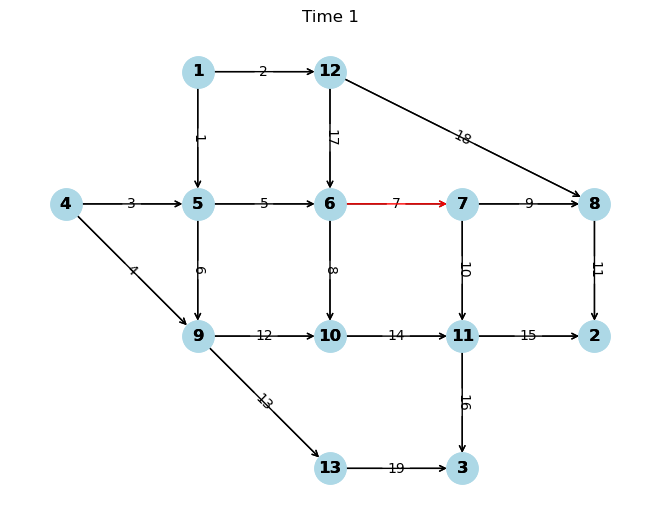

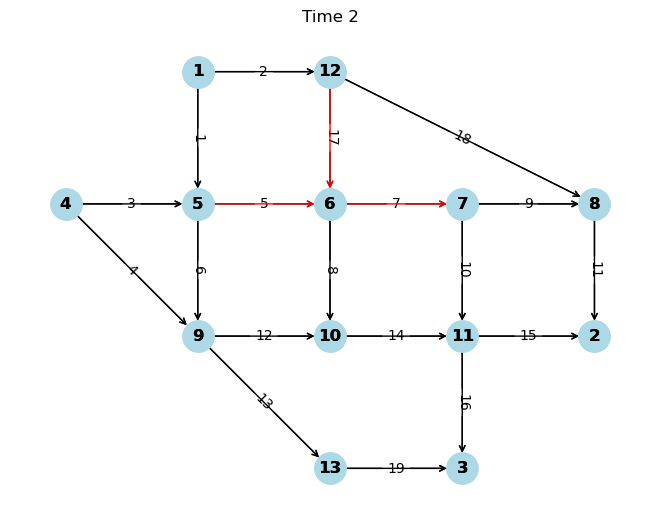

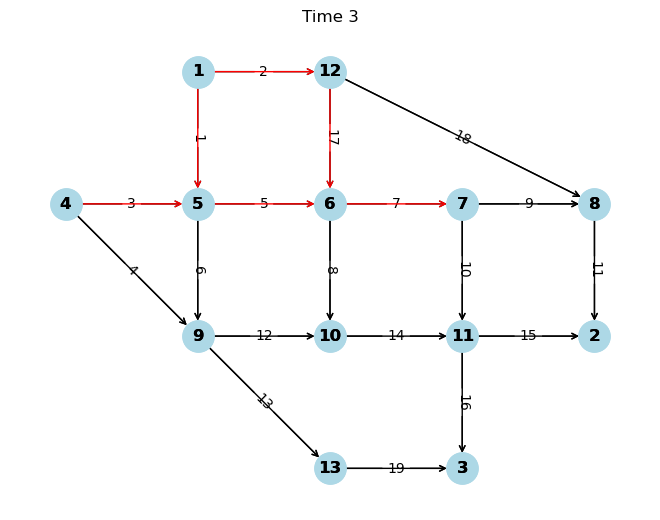

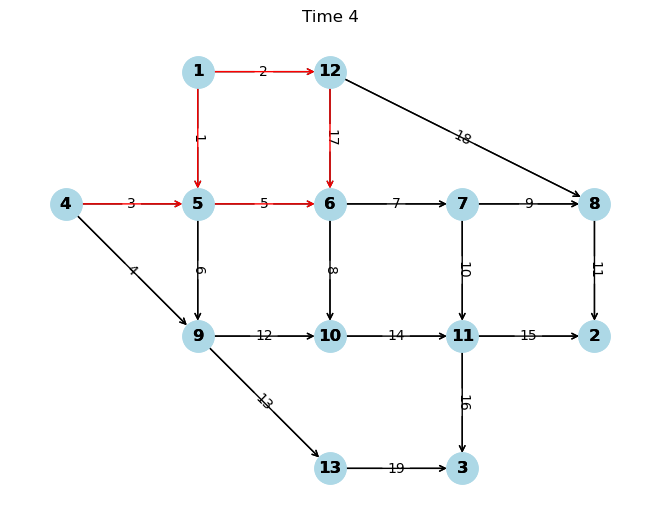

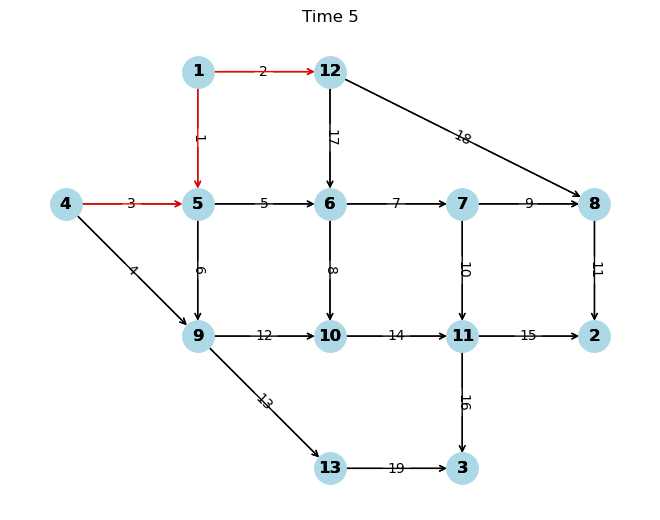

In [73]:
# 求解模型
run()




